Topic Modelling by using LDA

In [1]:
import pandas as pd

# load dataset
dataset_path = 'balanced_category.csv'
df = pd.read_csv(dataset_path)
# df = df[['text','category']]

print(df['category'].value_counts())

category
business         1000
entertainment    1000
health           1000
news             1000
opinions         1000
politics         1000
sport            1000
us               1000
world            1000
weather           570
Name: count, dtype: int64


Feature Extraction (TF-IDF and BoW)

In [ ]:
# use tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_doc_term_matrix = tfidf_vectorizer.fit_transform(df['text'])

In [ ]:
tfidf_doc_term_matrix.shape

In [2]:
# use bow vectorizer

from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer()
bow_doc_term_matrix = bow_vectorizer.fit_transform(df['text'])


In [3]:
bow_doc_term_matrix.shape

(9570, 25301)

LDA Model

In [4]:
from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.decomposition import LatentDirichletAllocation

#lda model
n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=100, n_jobs=1)
lda.fit(bow_doc_term_matrix)  # can CHANGE

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


LatentDirichletAllocation(max_iter=100, n_jobs=1, random_state=42)

MLflow Server

In [5]:
import mlflow
from mlflow.tracking import MlflowClient

# convert model name to string
model_name = lda.__class__.__name__
vectorizeer_name = bow_vectorizer.__class__.__name__   #can CHANGE

# start MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("topic-modelling")

# initialize MLflow client
client = MlflowClient()

# experiment ID
experiment_id = client.get_experiment_by_name("topic-modelling").experiment_id

runs = client.search_runs(experiment_ids=[experiment_id])

# initial version to 0
max_version = 0

# find the max version for the current version model
for run in runs:
    run_name = run.data.tags.get('mlflow.runName')
    if run_name and run_name.startswith(model_name):        
        # extract version number from the run name
        try:
            version = int(run_name.split('_v')[-1])
        except ValueError:
            continue  # skip if version is not an integer

        # update max_version if this version is greater
        max_version = max(max_version, version)

# increase the version by adding 1
new_version = max_version + 1

# new run name
new_run_name = f"{model_name}_v{new_version}"
mlflow.start_run(run_name=new_run_name)

mlflow.log_param("model name", model_name)
mlflow.log_param("vectorizer name", vectorizeer_name)
mlflow.log_param("dataset_name", dataset_path)
mlflow.log_param("data size", df.shape)


(9570, 2)

Word Cloud for 10 topics

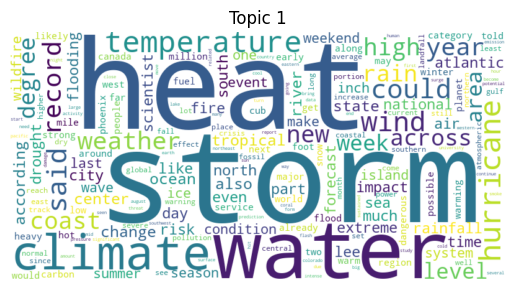

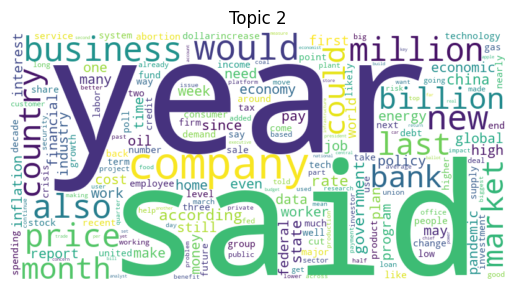

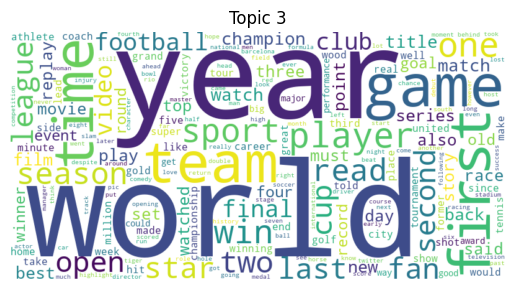

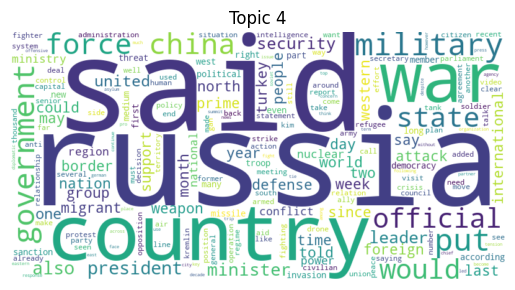

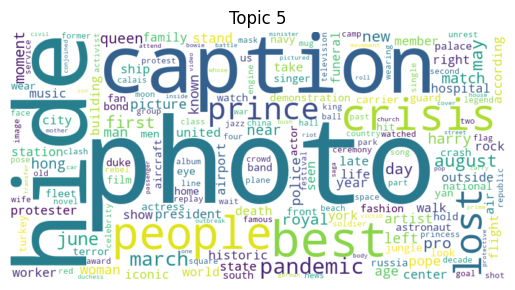

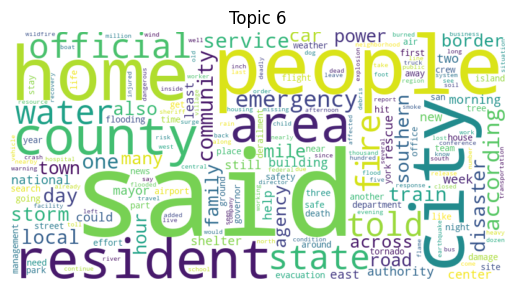

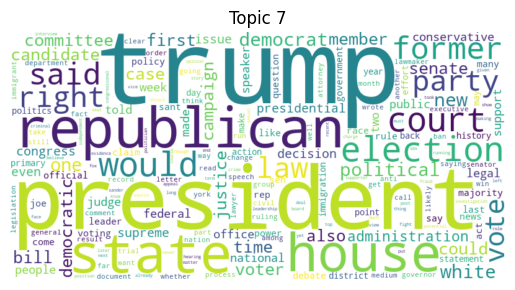

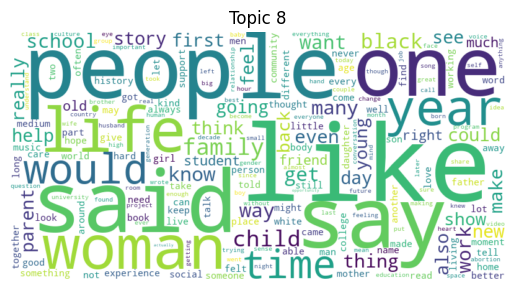

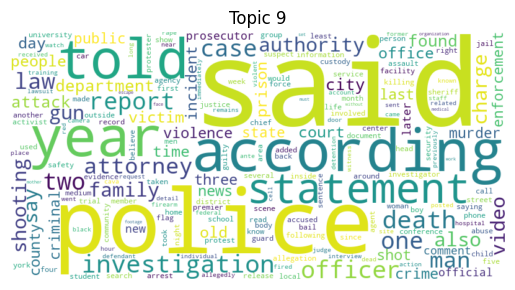

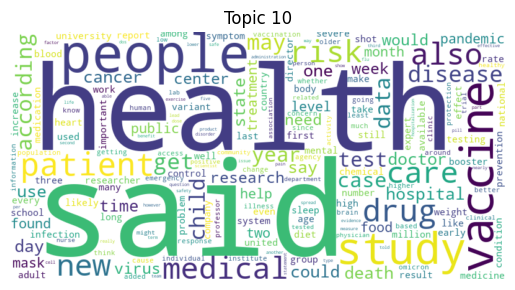

In [6]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

feature_names = bow_vectorizer.get_feature_names_out()   # can CHANGE

for i, topic in enumerate(lda.components_):
    plt.figure()
    wordcloud = WordCloud(width=800, height=400, background_color='white').fit_words(dict(zip(feature_names, topic)))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {i+1}')
    plt.show()


Topic Words Score visualization

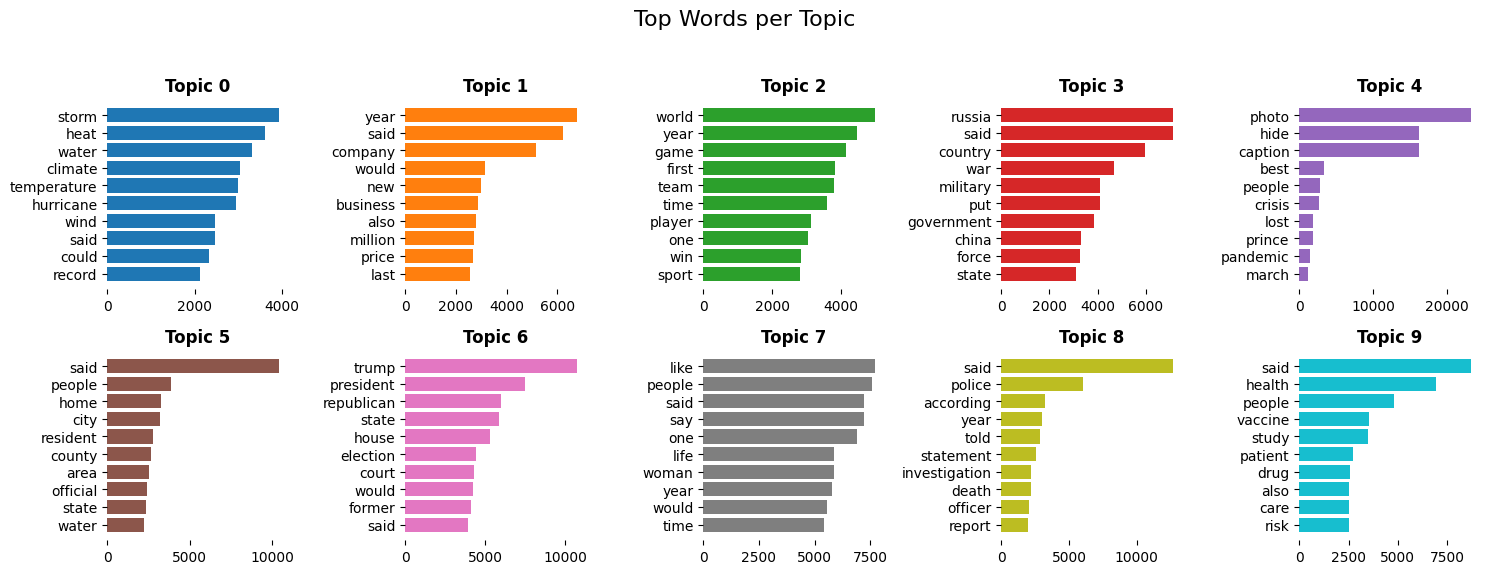

In [7]:
import numpy as np

# colors for each topic
colors = plt.cm.tab10(np.linspace(0, 1, 10))

# subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=False, sharey=False)
axes = axes.flatten()

for i, (topic, color) in enumerate(zip(lda.components_, colors)):
    top_words_idx = np.argsort(topic)[::-1][:10]  # descending order
    top_words = feature_names[top_words_idx]
    top_scores = topic[top_words_idx]

    ax = axes[i]
    ax.barh(top_words, top_scores, color=color)
    ax.set_title(f'Topic {i}', fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=10)
    for spine in ax.spines.values():
        spine.set_visible(False)

fig.suptitle('Top Words per Topic', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Using Gensim to calculate the Coherence Scores and Visualize Intertopic Chart

In [8]:
from gensim.corpora.dictionary import Dictionary

# create dic, corpus and tokenized
tokenized_docs = [doc.split() for doc in df['text']]
dictionary = Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

Visualize in intertopic

In [ ]:
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# pyLDAvis
lda_gensim = LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topics)
vis_data = gensimvis.prepare(lda_gensim, corpus, dictionary)
pyLDAvis.display(vis_data)

Evaluate by Coherence Scores with c_v and u_mass

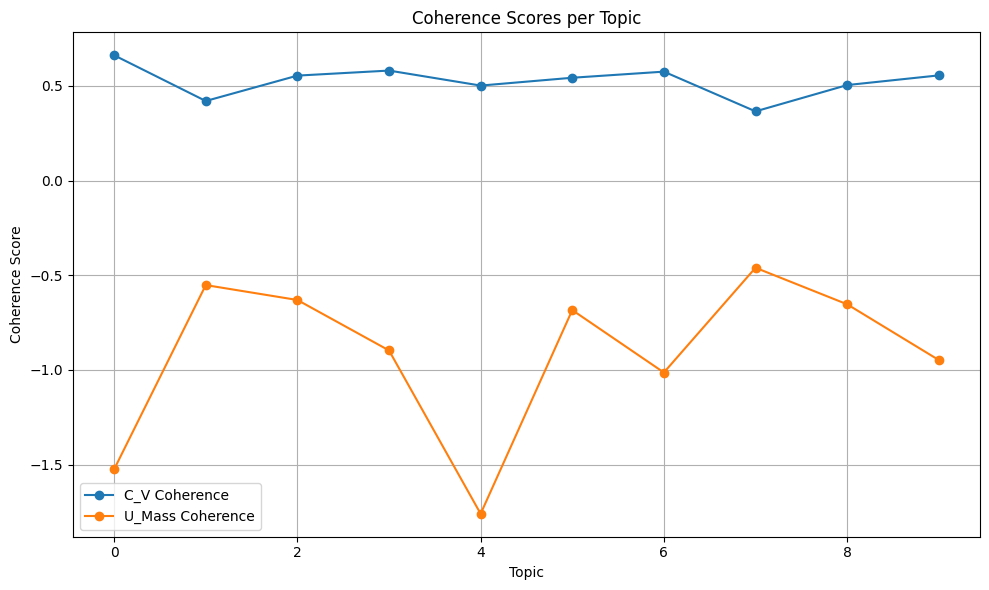

Overall C_V Coherence Score: 0.5265640427960986
Overall U_Mass Coherence Score: -0.9126012867336305


In [9]:
from gensim.models import CoherenceModel
topics = lda.components_

# convert topics to words
top_words_per_topic = []
for topic in topics:
    top_words_idx = topic.argsort()[-10:]  # Get indices of the top words for this topic
    top_words = [feature_names[i] for i in top_words_idx]
    top_words_per_topic.append(top_words)

# C_V coherence score
cv_coherence_model = CoherenceModel(topics=top_words_per_topic, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
cv_coherence = cv_coherence_model.get_coherence()

# U_Mass coherence score
umass_coherence_model = CoherenceModel(topics=top_words_per_topic, corpus=corpus, dictionary=dictionary, coherence='u_mass')
umass_coherence = umass_coherence_model.get_coherence()


plt.figure(figsize=(10, 6))

plt.plot(range(n_topics), cv_coherence_model.get_coherence_per_topic(), marker='o', label='C_V Coherence')

plt.plot(range(n_topics), umass_coherence_model.get_coherence_per_topic(), marker='o', label='U_Mass Coherence')

plt.xlabel('Topic')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores per Topic')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

print(f"Overall C_V Coherence Score: {cv_coherence}")
print(f"Overall U_Mass Coherence Score: {umass_coherence}")

mlflow.log_metric("c_v coherence", cv_coherence)
mlflow.log_metric("u_mass coherence", umass_coherence)



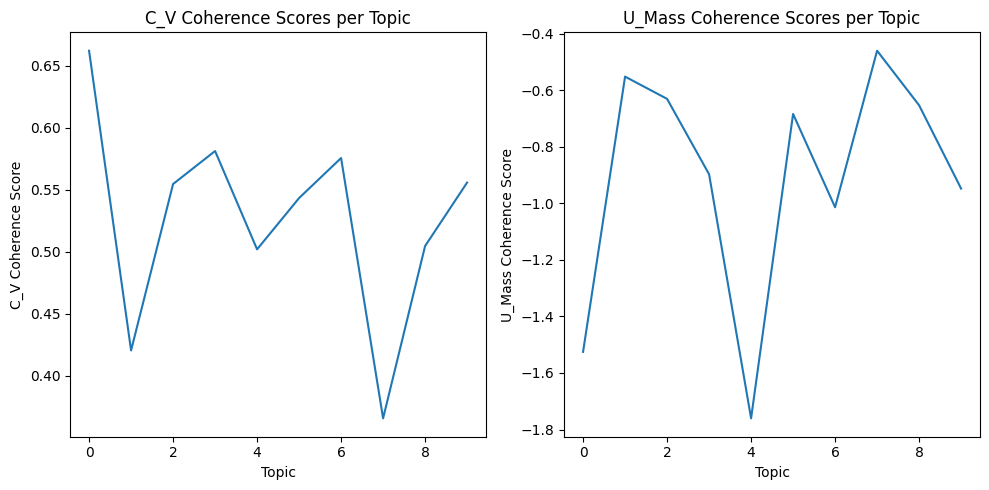

Overall C_V Coherence Score: 0.5265640427960986
Overall U_Mass Coherence Score: -0.9126012867336305


In [10]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(n_topics), cv_coherence_model.get_coherence_per_topic())
plt.xlabel('Topic')
plt.ylabel('C_V Coherence Score')
plt.title('C_V Coherence Scores per Topic')

plt.subplot(1, 2, 2)
plt.plot(range(n_topics), umass_coherence_model.get_coherence_per_topic())
plt.xlabel('Topic')
plt.ylabel('U_Mass Coherence Score')
plt.title('U_Mass Coherence Scores per Topic')

plt.tight_layout()
plt.show()

print(f"Overall C_V Coherence Score: {cv_coherence}")
print(f"Overall U_Mass Coherence Score: {umass_coherence}")

Save Model

In [11]:
import joblib

joblib.dump(lda, 'lda_bow_with_balance.pkl')
joblib.dump(bow_vectorizer, 'bow_vectorizer_with_balance.pkl')   #can CHANGE


['bow_vectorizer_with_balance.pkl']